# Topic 7: Working with Named Entities¶

## Preliminaries 
Run this cell.

In [12]:
import sys
sys.path.append(r'\\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources')
#sys.path.append(r'/Users/davidw/Documents/teach/NLE/resources')
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
from itertools import zip_longest
from IPython.display import display
from random import seed
import random
import math
from pylab import rcParams
from operator import itemgetter, attrgetter, methodcaller
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import csv
from operator import itemgetter, attrgetter, methodcaller
import matplotlib.pylab as pylab
%matplotlib inline
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
get_ipython().magic('matplotlib inline')


## Overview
In this topic you will be looking at the identification of **named entities**, i.e. identifying referrences to entities in a text. This is also sometimes referred to as **entity extraction** or **named entity recognition**. A reference to a named entity in a text is referred to as an **entity mention**.

We will be extracting entities from novels and exploring the way that the different characters in the novel are characterised: what sort of things are they doing and what sort of things are being done to them.

Once we have done that, we will set up a function that classifes names as being female or male. This will then be used to investigate  differences in the way that an author characterises characters that are female from those that are male.


### Exercise
In preparation for what comes later in this notebook, run the cell below. This sets up spaCy, and loads and runs spaCy on a number of books from the Gutenberg corpus, in particular:
- [Herman Melville's Moby Dick][1]
- [Lewis Carroll's Alice in Wonderland][2]
- [Jane Austen's Emma][3]
- [Jane Austen's Persuasion][4] (optional)
- [Jane Austen's Sense and Sensibility][5] (optional)
[1]: https://en.wikipedia.org/wiki/Moby-Dick
[2]: https://en.wikipedia.org/wiki/Alice%27s_Adventures_in_Wonderland
[3]: https://en.wikipedia.org/wiki/Emma_(novel)
[4]: https://en.wikipedia.org/wiki/Persuasion_(novel)
[5]: https://en.wikipedia.org/wiki/Sense_and_Sensibility


In [30]:
import spacy
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from nltk.corpus import gutenberg
nlp = spacy.load('en')
#moby = gutenberg.raw('melville-moby_dick.txt')
emma = gutenberg.raw('austen-emma.txt')
#alice = gutenberg.raw('carroll-alice.txt')
#persuasion = gutenberg.raw('austen-persuasion.txt')
#sense = gutenberg.raw('austen-sense.txt')
#parsed_moby = nlp(moby)
parsed_emma = nlp(emma)
#parsed_alice = nlp(alice)
#parsed_persuasion = nlp(persuasion)
#parsed_sense = nlp(sense)

## Noun phrase chunks
Before we consider named entity extraction, we will briefly look at the problem of identifying base noun phrases or noun chunks. This is relevent because entity mentions are noun phrases.
- A base noun phrase or noun chunk is a noun phrase that doesn't contain within it another noun phrase.

spaCy identifies the base noun phrases in a sentence.

### Exercise
Look art the code cell below and make sure you understand how works.
- `noun_chunks` is a property of document objects (of type `Doc`). 
- `noun_chunks` returns a `span` which is a slice from a document. Sentences are also spans.

Run the cell 
- What is being shown in the second column of the table (column 1)?
- Notice that some of the base noun phrases contain the `\n`. 
- To remove `\n`, edit to code using `re.sub("\s+"," ",<string>)`, to substitute all substrings consisting of one or more whitespace characters (captured with the regular expression `"\s+"`) with a single space character, `" "`.

<b>SOLVED:</b>

In [31]:
text = parsed_emma
nounphrases = [[nounphrase.text, nounphrase.root.head.text] for nounphrase in parsed_emma.noun_chunks]
print("There were {} noun phrases found.".format(len(nounphrases)))
display(pd.DataFrame(nounphrases))

There were 40676 noun phrases found.


,0,1
0,Jane Austen,by
1,I,seemed
2,a comfortable home,with
3,disposition,home
4,the best blessings,of
5,existence,of
6,nearly twenty-one years,lived
7,the world,in
8,her,vex
9,She,was


### Named Entity Recognition
Noun phrases in a document can refer to entities such as people, places, organisations, times, etc. These noun phrases are **entity mentions**.

Named Entity Recognition (NER) refers a process in which two things are achieved: 
1. identifying the location of a phrase within the text that is an entity mention, and 
2. determining the type of entity that the entity mention is referring to.

spaCy labels base noun phrases with their entity type. 

Here is a summary of spaCy's entity types.

TYPE | DESCRIPTION
:----: |---
`PERSON` | People, including fictional
`NORP` | Nationalities or religious or political groups
`FACILITY` | Buildings, airports, highways, bridges, etc
`ORG` | Companies, agencies, institutions, etc
`GPE` | Countries, cities, states
`LOC` | Non-GPE locations, mountain ranges, bodies of water
`PRODUCT` | Objects, vehicles, foods, etc (Not services)
`EVENT` | Named hurricanes, battles, wars, sports events, etc
`WORK_OF_ART` | Titles of books, songs, etc
`LAW` | Named documents made into laws
`LANGUAGE` | Any named language
`DATE` | Absolute or relative dates or periods.
`TIME` | Times smaller than a day
`PERCENT` | Percentage, including "%".
`MONEY` | Monetary values, including unit
`QUANTITY` | Measurements, as of weight or distance
`ORDINAL` | "first", "second", etc
`CARDINAL` | Numerals that do not fall under another type


More details can be found [here](https://spacy.io/docs/usage/entity-recognition#entity-types).

### Exercise
Spend some time exploring spaCy's NER functionality by using the interactive demo found [here](https://demos.explosion.ai/displacy-ent/). 

In particular, you should:
- change the seed in the following cell to use your candidate number 
- run the cell so that it produces a random sample of 20 sentences from Jane Austen's Emma
- for each sentence in the random sample:
 - copy the sentence from this notebook and paste it into the [displaCy Named Entity Visualizer](https://demos.explosion.ai/displacy-ent/)
 - assess the extent to which the named entity annotations that have been produced are accurate
 - what proportion of the named entities have been identified as some form of named entity?
 - what proportion of the named entities have been correctly classified (in terms of the entity type).

The results of this analysis can be recorded with a **Confusion matrix**. For example, in the table shown below,  the count c would be placed in cell (i,j) when c occurrences of the ith entity type in a sample are labelled by the entity extractor as having the jth entity type.

For example if an `ORG` is (incorrectly) labelled as a `GPE` 15 times then 15 will appear in (4,5), as shown.

For entries where i=j, we will see counts showning how often the entity extractor correctly identified the ith entity type.

 | `PERSON` | `NORP` | `FACILITY` | `ORG` | `GPE` | `LOC` | `PRODUCT` | `EVENT` | `WORK_OF_ART` | `LAW` | `DATE` | `PERCENT` | `TIME` | `MONEY` | `QUANTITY` | `ORDINAL` | `CARDINAL` | 
:----: |---
`PERSON` | | | | | | | | | | | | | | | | |
`NORP` | | | | | | | | | | | | | | | | |
`FACILITY` | | | | | | | | | | | | | | | | |
`ORG` | | | | | 15| | | | | | | | | | | |
`GPE` | | | | | | | | | | | | | | | | |
`LOC` | | | | | | | | | | | | | | | | |
`PRODUCT` | | | | | | | | | | | | | | | | |
`EVENT` | | | | | | | | | | | | | | | | |
`WORK_OF_ART` | | | | | | | | | | | | | | | | |
`LAW` | | | | | | | | | | | | | | | | |
`LANGUAGE` | | | | | | | | | | | | | | | | |
`DATE` | | | | | | | | | | | | | | | | |
`TIME` | | | | | | | | | | | | | | | | |
`PERCENT` | | | | | | | | | | | | | | | | |
`MONEY` | | | | | | | | | | | | | | | | |
`QUANTITY` | | | | | | | | | | | | | | | | |
`ORDINAL` | | | | | | | | | | | | | | | | |
`CARDINAL` | | | | | | | | | | | | | | | | |

Make a copy of the above table and complete it for your sample.

<b> Solved:</b>
<p>Out of 20 random samples, 12 PERSON entites are correctly classified. However, 1 ORG entity has been wrongly classified which is actually None.</p>

<p>Sentence 1: she was considerably worse from this reappearance of Mr. <u>Elton</u>(PERSON).</p>

<p>Sentence 2: . I could not have believed it!<br />
Sentence 3: Be observant of him.<br />
Sentence 4: Then the baked apples came home, Mrs. <u>Wallis</u>(PERSON) sent them by her boy; they are extremely civil and obliging to us, the <u>Wallises</u>(PERSON), always--I have heard some people say that Mrs. <u>Wallis</u>(PERSON) can be uncivil and give a very rude answer, but we have never known any thing but the greatest attention from them.<br />
Sentence 5: &quot;I certainly will come.<br />
Sentence 6: I never saw any thing equal to the comfort and style--Candles everywhere.--&nbsp;</p>

<p>Sentence 7: But it would not do.</p>

<p>Sentence 8: &quot;They told me something,&quot; said Harriet rather hesitatingly;&quot; but it is nothing of any consequence.&quot;<br />
Sentence 9: You like Mr. <u>Elton</u>(PERSON), papa,--I must look about for a wife for him.<br />
Sentence 10: well, that must be infinitely provoking!<br />
Sentence 11: You only mean, that he intends it.&quot; &quot;I mean that he has done it,&quot; answered Mr. <u>Knightley</u>(PERSON), with smiling but determined decision, &quot;and been accepted.</p>

<p>Sentence 12: It could be protracted no longer.<br />
Sentence 13: &quot;It is certainly very well regulated.&quot; &quot;So seldom that any negligence or blunder appears!<br />
Sentence 14: &quot;Now,&quot;--said <u>Emma</u>(PERSON), when they were fairly beyond the sweep <u>gates,--</u>(ORG) &quot;now Mr. <u>Weston</u>(PERSON), do let me know what has happened.&quot;<br />
Sentence 15: He could not meet her in conversation, rational or playful.</p>

<p>Sentence 16: What has he been judging by?--&nbsp;</p>

<p>Sentence 17: Mr. <u>Woodhouse</u>(PERSON) was quite at ease; and the seeing him so, with the arrival of the little boys and the philosophic composure of her brother on hearing his fate, removed the chief of even <u>Emma</u>(PERSON)&#39;s vexation.<br />
Sentence 18: Mrs. <u>Weston</u>(PERSON), you would be quite laid up; do not let them talk of such a wild thing.<br />
Sentence 19: And yet it is formal.<br />
Sentence 20: &quot;Mrs. <u>Cole</u>(PERSON) has servants to send.&nbsp;</p>

<p>&nbsp;</p>

<table>
	<thead>
		<tr>
			<th style="text-align:center">&nbsp;</th>
			<th><code>PERSON</code></th>
			<th><code>NORP</code></th>
			<th><code>FACILITY</code></th>
			<th><code>ORG</code></th>
			<th><code>GPE</code></th>
			<th><code>LOC</code></th>
			<th><code>PRODUCT</code></th>
			<th><code>EVENT</code></th>
			<th><code>WORK_OF_ART</code></th>
			<th><code>LAW</code></th>
			<th><code>DATE</code></th>
			<th><code>PERCENT</code></th>
			<th><code>TIME</code></th>
			<th><code>MONEY</code></th>
			<th><code>QUANTITY</code></th>
			<th><code>ORDINAL</code></th>
			<th><code>CARDINAL</code></th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td style="text-align:center"><code>PERSON</code></td>
			<td>12</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>NORP</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>FACILITY</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>ORG</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>GPE</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>LOC</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>PRODUCT</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>EVENT</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>WORK_OF_ART</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>LAW</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>LANGUAGE</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>DATE</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>TIME</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>PERCENT</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>MONEY</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>QUANTITY</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>ORDINAL</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td style="text-align:center"><code>CARDINAL</code></td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
	</tbody>
</table>


### Exercise
Let's explore the named enties that appear in our novels. 

Have a look at the definition of `named_entity_counts` in the next cell.
- `document.ents` gives all of the named entities in `document`.
- `ent.label_` gives the label of the named entity.
- `ent.string.strip()` strips whitespace around the entities string.
- The condition `ent.string.strip()` checks that the string isn't empty.
- `Counter` assembles the count of each named entity. Note that `Counter` is imported from `collections`.
- `.most_common(number_of_entities)`  arranges the named entities in descending order of their count and give the top `number_of_entities` of them.

Run the following cell, and by changing the value of `text` and `entity_type`, apply the `named_entity_counts` function to each of the three texts and with different kinds of named entities. This should provide a good idea as to the characters in each novel.

In [24]:
def named_entity_counts(document,named_entity_label):
    occurrences = [ent.string.strip() for ent in document.ents 
                   if ent.label_ == named_entity_label and ent.string.strip()]
    return Counter(occurrences)

text = parsed_emma
entity_type = 'PERSON'
number_of_entities = 10
display(pd.DataFrame(named_entity_counts(text,entity_type).most_common(number_of_entities),columns=["Entity Mention","Count"]))

,Entity Mention,Count
0,Emma,827
1,Harriet,441
2,Weston,423
3,Elton,376
4,Knightley,286
5,Woodhouse,187
6,Jane,176
7,Frank Churchill,119
8,Miss Woodhouse,95
9,Jane Fairfax,82


### Exercise
Look at the code in the next code cell and run it.

It contains code that plots positions in a document where characters are mentioned.
- `ent.root.i` gives the location (token index) of the token that is the root token of the entity.
- `ent.string.strip().lower()` gives the lower case string for the entity with whitespace removed.
- `pd.Series(np.histogram(list_of_indices,bins=num_bins)` bins the `list_of_indices` into `num_bins` bins. This returns a list of two lists:
 - the first element is the counts of each bin, i.e., 100 counts
 - the second element is indices that form the boundaries between each bin, i.e. 101 indices.
- `[0]` is therefore used to select the first list since that is what we need on this occasion.



array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A0D0404908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001A0D0579320>], dtype=object)

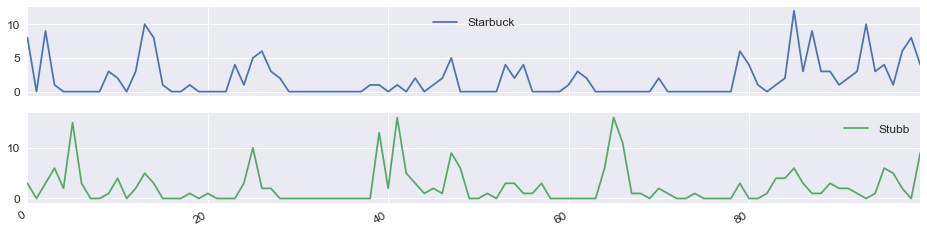

In [25]:
rcParams['figure.figsize'] = 16, 4

def locations(target_token, document,num_bins): 
    list_of_indices = [ent.root.i for ent in document.ents if ent.string.strip().lower() == target_token]
    return pd.Series(np.histogram(list_of_indices, bins=num_bins)[0])

text = parsed_moby
number_of_bins = 100
characters = {'Starbuck', 'Stubb'}
pd.DataFrame(
    {name: locations(name.lower(),text,number_of_bins) 
     for name in characters}).plot(subplots=True)


### Exercise
Reusing code from the previous two cells as appropriate, write a function:  
`show_top_entities(entity_label,document,k,bin_size)`  
where:
- `entity_label` is one of the named entity types.
- `document` is a parsed text.
- `k` is a positive integer indicating the number of entities that we are interested in.
- `bin_size` is the number of different bins that the token positions in the document are placed in.

The output is a plots of the mentions of the `k` most common entities labelled `entity_label` in `document`.

Run your function `show_top_entities` on each of our novels to find out when the main characters appear together.

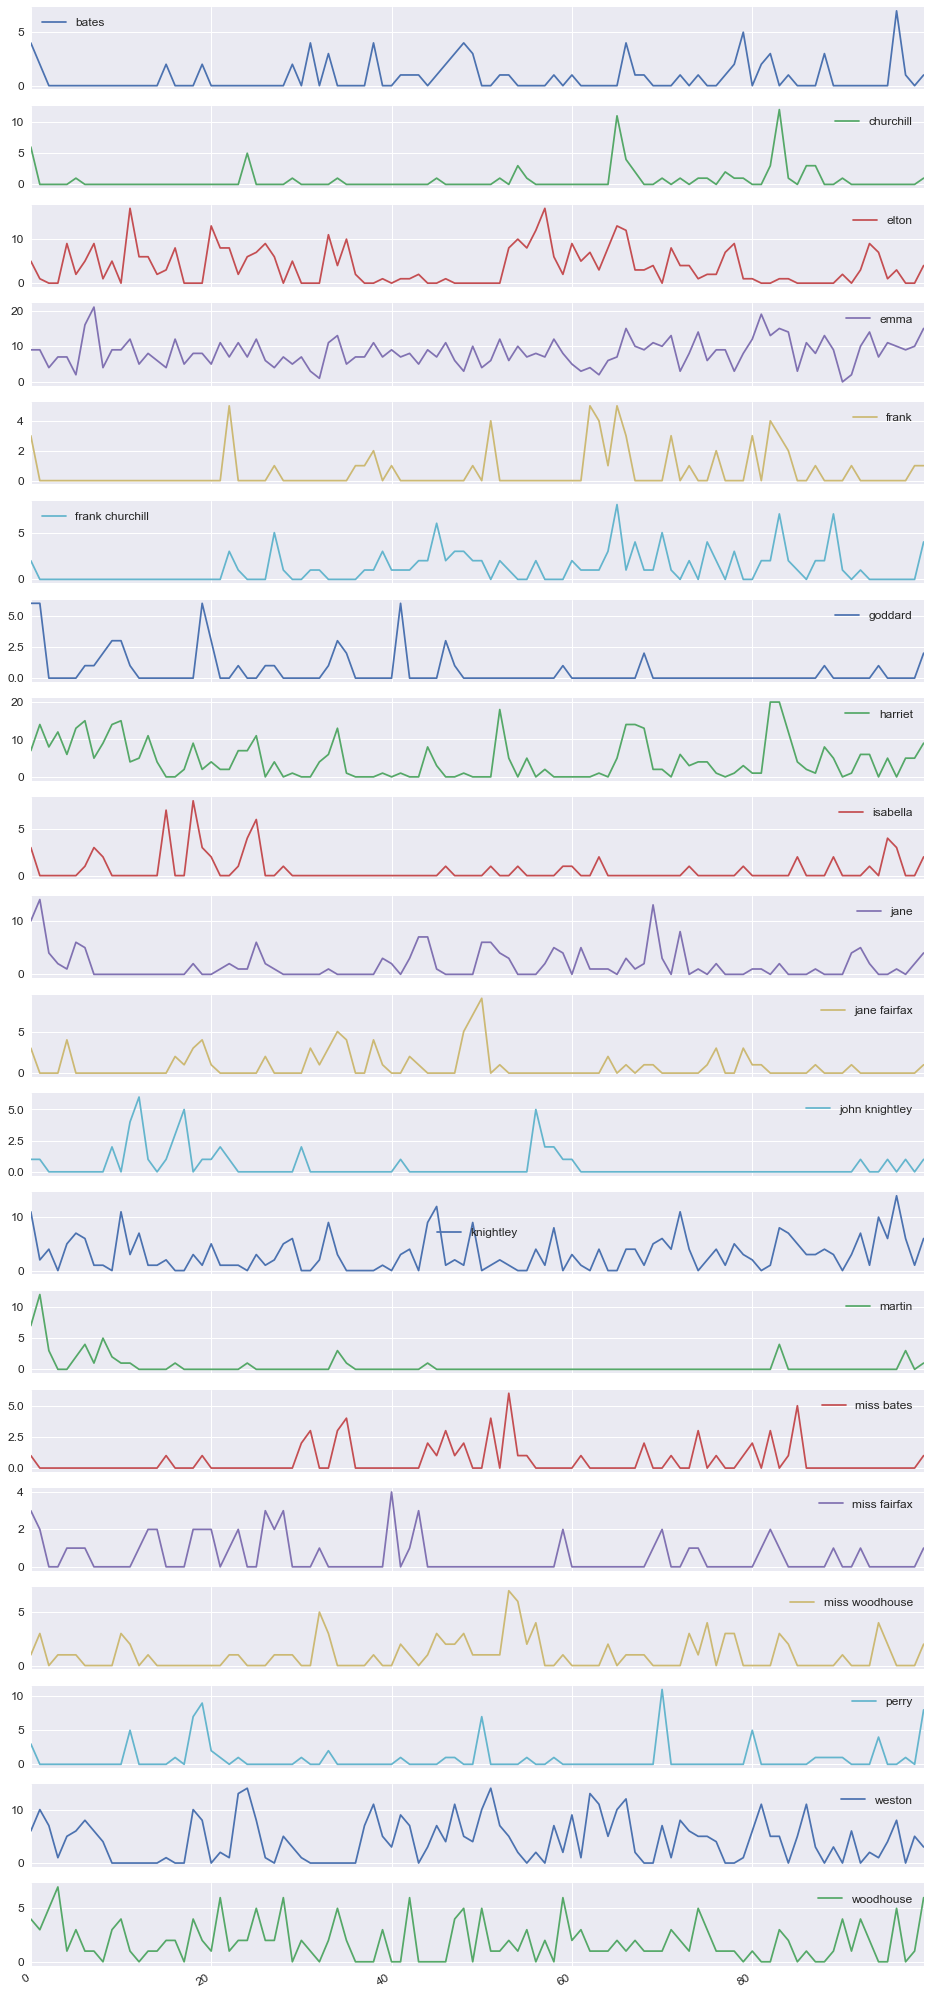

In [28]:
# %load solutions/show_top_entities
from pylab import rcParams

def locations(target_token, document,num_bins): 
    list_of_indices = [ent.root.i for ent in document.ents if ent.string.strip().lower() == target_token]
    return pd.Series(np.histogram(list_of_indices, bins=num_bins)[0])
    
def named_entity_counts(document,label):
    occurrences = [ent.string.strip().lower() for ent in document.ents 
                   if ent.label_ == label and ent.string.strip()]
    return Counter(occurrences)

def show_top_entities(entity_label,document,k,num_bins):
    rcParams['figure.figsize'] = 16, k*2
    top_people_counts = named_entity_counts(document,entity_label).most_common(k)
    top_people = {person for person,count in top_people_counts}
    pd.DataFrame(
    {name: locations(name.lower(),document,num_bins) 
     for name in top_people}).plot(subplots=True)

text = parsed_emma
number_of_people = 20
number_of_bins = 100

show_top_entities("PERSON",text,number_of_people,number_of_bins)


## Exploring gender differences

In the next topic, we will be looking at how to determine, for a given author or authors, whether there are differences in portrail of characters based on gender. 

Our final task in this notebook is to define a function that guesses the gender of a character based on his or her name.  

We have provided a csv file called `names.csv` that contains several thousand male and female names with information about how frequent each name is. 

We can read in the contents of this file with this line of python:  

```
input_file = csv.DictReader(open("names.csv"))
```

See [here](https://docs.python.org/3/library/csv.html) for description of `DictReader`.

The first few lines of this CSV file are as follows:
```
name,freq,gender
MARY,2.629,female
PATRICIA,1.073,female
LINDA,1.035,female
BARBARA,0.980,female
ELIZABETH,0.937,female
JENNIFER,0.932,female
MARIA,0.828,female
SUSAN,0.794,female
MARGARET,0.768,female
```

The second value on each line is a measure of how common the name is. This will be useful since some of the names listed in `names.csv` appear as both the female and male. We therefore need to establish which gender is more likely in these cases. 

To do this, use the function, `create_gender_map`, defined as follows:

```
def create_gender_map(dict_reader):
    names_info = defaultdict(lambda: {"gender":"", "freq": 0.0})
    for row in input_file:
        name = row["name"].lower()
        if names_info[name]["freq"] < float(row["freq"]): # is this gender more frequent?
            names_info[name]["gender"] = row["gender"] 
            names_info[name]["freq"] = float(row["freq"])
    gender_map = defaultdict(lambda: "unknown")
    for name in names_info:
        gender_map[name] = names_info[name]["gender"]
    return gender_map
```

- `create_gender_map` uses `names_info` which is a dictionary where the keys are all of the lowercase strings produced from the names that appear in `names.csv`. Each name maps to a dictionary that has just two keys: `"freq"` and `"gender"`. The key `"freq"` maps to the frequency of the name, and the key `"gender"` maps to the gender `"male"` or `"female"`.

- `create_gender_map` returns `gender_map` which is a dictionary where the keys are all of the lowercase strings produced from the names that appear in `names.csv`. Each name maps to the most likely gender for that name according to the contents of `names.csv`, or `"unknown"` when the name does not appear in `names.csv`.


The following line warrants an explanation.
```
        if names_info[name]["freq"] < float(row["freq"]): # is this gender more frequent?
```

The condition on this line will be true in two quite different cases:
- when `name` has not been seen before, in which case `names_info[name]["freq"]` is the default value `0.0`
 - see the line `names_info = defaultdict(lambda: {"gender":"", "freq": 0.0})`
- when `name` has been seen, but we have now found the more frequent gender for `name`.


### Exercise
Look through the following code cell and make sure you understand how it works - you are going to be adapting it.

In [29]:
def create_gender_map(dict_reader):
    names_info = defaultdict(lambda: {"gender":"", "freq": 0.0})
    for row in input_file:
        name = row["name"].lower()
        if names_info[name]["freq"] < float(row["freq"]): # is this gender more frequent?
            names_info[name]["gender"] = row["gender"] 
            names_info[name]["freq"] = float(row["freq"])
    gender_map = defaultdict(lambda: "unknown")
    for name in names_info:
        gender_map[name] = names_info[name]["gender"]
    return gender_map

input_file = csv.DictReader(open("names.csv"))
gender_map = create_gender_map(input_file)

FileNotFoundError: [Errno 2] No such file or directory: 'names.csv'

### Exercise
Let's see how well this works.

- Run the cell below to display the result of running `guess_gender` on the 10 most common characters in Jane Austen's Emma. 

- Try repeating this for some of the other texts.


In [ ]:
def named_entity_counts(document,named_entity_label):
    occurrences = [ent.string.strip() for ent in document.ents
                   if ent.label_ == named_entity_label and ent.string.strip()]
    return Counter(occurrences)

text = parsed_emma
entity_type = 'PERSON'
number_of_entities = 10
names_with_gender = [(name,gender_map[name.lower()]) for name,count in named_entity_counts(text,entity_type).most_common(number_of_entities)]
display(pd.DataFrame(names_with_gender,columns=["Name","Gender"]))

### Exercise

As you have now seen, many of the named entities involve multiple tokens. 
- In some cases, the full name is given, e.g. `Frank Churchill`
- In some cases, a title is used, e.g. `Miss Bates`

For this exercise you should extend the gender map so that it handles these cases.

- First, define a function `guess_gender(name,gender_map)` that returns `gender_map[name]` when we (think we) know the gender of `name`, but when `name` does not appear in `gender_map` (i.e. maps to the `'unknown'`) it strips off all but the first token of `name` and tries that instead.

- Second, write a function `extend_gender_map(gender_map)` that returns a gender map with additional mappings added for as many male and female titles as you can think of.

- Third, adapt the line in the above cell 
```
names_with_gender = [(name,gender_map[name.lower()]) for name,count in named_entity_counts(text,entity_type).most_common(number_of_entities)]
```
to use your `guess_gender` function rather than directly applying `gender_map`.

<b> Solved:</b>

In [ ]:
def guess_gender(name, gender_map):
    if gender_map[name] == "unknown":
        tokens = name.split()
        new_mapping = gender_map[tokens[0]]
        if new_mapping != "unknown":
            for token in tokens[1:]:
                gender_map[token] = new_mapping
        return new_mapping
    return gender_map[name]

def extend_gender_map(dict_reader):
    names_info = defaultdict(lambda: {"gender":"", "freq": 0.0})
    for row in input_file:
        name = row["name"].lower()
        if names_info[name]["freq"] < float(row["freq"]): # is this gender more frequent?
            names_info[name]["gender"] = row["gender"] 
            names_info[name]["freq"] = float(row["freq"])
    gender_map = defaultdict(lambda: "unknown")
    for name in names_info:
        gender_map[name] = names_info[name]["gender"]
    gender_map["miss."] = "female"
    gender_map["miss"] = "female"
    gender_map["mrs"] = "female"
    gender_map["mrs."] = "female"
    gender_map["mr."] = "male"
    gender_map["mr"] = "female"
    return gender_map

input_file = csv.DictReader(open("names.csv"))
gender_map = extend_gender_map(input_file)

names_with_gender = [(name, guess_gender(name.lower(),gender_map)) for name,count in named_entity_counts(text,entity_type).most_common(number_of_entities)]
display(pd.DataFrame(names_with_gender,columns=["Name","Gender"]))

### Exercise

Now run your improved gender classifier on some of the novels to see how well it works.

### Exercise

If you are feeling ambitious then one additional extension you could make would be to deal with situations where at one point in a novel we see a name that we can deal with (e.g. "John Smith" or "Mr Smith"), and then later we see just "Smith". This would require novel specific additions to the gender classifier.

In [ ]:
names_with_gender = [(name, guess_gender(name.lower(),gender_map)) for name,count in named_entity_counts(text,entity_type).most_common(number_of_entities)]
display(pd.DataFrame(names_with_gender,columns=["Name","Gender"]))
# Now, you can see woodhouse is recognized as female below while it is unknown in upper cell! Bonus Marks :)